In [1]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from datetime import datetime
from dateutil.relativedelta import *
from matplotlib.dates import DateFormatter
from matplotlib.ticker import AutoMinorLocator
from notebook_utils import configure_path, setup_matplotlib

In [2]:
configure_path()
setup_matplotlib()

## Access to Google’s Public DNS

Launched as an experimental component of Google’s “Make The Web Faster” project, Google Public DNS (GPDNS), the first public DNS service, debuted on December 3, 2009. Utilizing global anycast addresses 8.8.8.8 and 8.8.4.4, it processes DNS queries from clients, with requests routed through Google’s autonomous system along the shortest announced path. The expansion and near pervasiveness of the GPDNS platform suggest that the quality of paths to this infrastructure can serve as proxy for Internet users’ overall Quality of Experience (QoE).

We use RIPE Atlas’ platform-wide traceroute campaign to exam- ine the evolution of RTT latency values in Venezuela and the rest of the LACNIC region to GPDNS. We compute the minimum RTT from each probe in each monthly snapshot to remove any transient sources of noise (e.g., diurnal congestion).

More information about RIPE Atlas can be found on its site https://atlas.ripe.net and its REST API Manual https://atlas.ripe.net/docs/apis/rest-api-manual for data retrieval

In [3]:
INIT_DATE = datetime(2014, 1, 1)

In [4]:
def accommodate_data(
    fmedian="data/processed/12-stable-set/medians-stable-set.csv.gz",
    fmean="data/processed/12-stable-set/means-stable-set.csv.gz",
):
    medians = pd.read_csv(fmedian, compression="gzip")
    means = pd.read_csv(fmean, compression="gzip")
    medians["epoch"] = medians["epoch"].map(str2datetime)
    means["epoch"] = means["epoch"].map(str2datetime)
    medians = medians.sort_values("epoch")
    means = means.sort_values("epoch")
    medians = medians.dropna()
    means = means.dropna()

    return medians, means


def str2datetime(t):
    return datetime.strptime(t, "%Y-%m-%d")

In [5]:
rir = pd.read_csv("data/external/rir.csv")

In [6]:
medians_rtt_lacnic, means_rtt_lacnic = accommodate_data(
    "data/processed/12-google-dns/medians_Latin America and Caribbean.csv.gz",
    "data/processed/12-google-dns/means_Latin America and Caribbean.csv.gz",
)

means_rtt_lacnic = means_rtt_lacnic.loc[means_rtt_lacnic["values"] > 0]
medians_rtt_lacnic = medians_rtt_lacnic.loc[medians_rtt_lacnic["values"] > 0]

We use RIPE Atlas’ platform-wide traceroute campaign to examine the evolution of RTT latency values in Venezuela and the rest of the LACNIC region to GPDNS.

We compute the minimum RTT from each probe in each monthly snapshot to remove any transient sources of noise (e.g., diurnal congestion).

In [7]:
def generate_filename(cc, d):
    dir = f"data/raw/12-20-google-dns/{cc}"

    return f"{dir}/{cc}_{d.strftime('%Y_%m_%d')}.csv.gz"


def get_prb_rtt(filename):
    """
    If routes experienced load balanced or route changes, a probe could have
    obtained more than one hops count to get to google
    """
    try:
        df = pd.read_csv(filename, compression="gzip")

        # This removes failed traceroutes that have TTL=255
        return (
            df.loc[df["hop"] < 60]
            .groupby("prb_id")["rtt"]
            .min()
            .reset_index()["rtt"]
            .values
        )
    except:
        return []

In [8]:
cc_median_rtts = []

for cc in rir.loc[rir["rir"] == "LACNIC"]["cc"].values.tolist():
    d = INIT_DATE

    while d < datetime.now():
        filename = generate_filename(cc, d)

        if os.path.exists(filename):
            rtts = get_prb_rtt(filename)
            m = np.median(rtts)

            cc_median_rtts.append((cc, d, m, len(rtts)))

        d += relativedelta(months=+1)

/home/santi/sos-ve/.sos-ve/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/santi/sos-ve/.sos-ve/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/santi/sos-ve/.sos-ve/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/santi/sos-ve/.sos-ve/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/santi/sos-ve/.sos-ve/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/santi/sos-ve/.sos-ve/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid valu

In [9]:
cc_median_rtts = pd.DataFrame(cc_median_rtts, columns=["cc", "date", "median", "prbs"])

In [10]:
cc_median_rtts.head()

,cc,date,median,prbs
0,AR,2014-01-01,NaN,0
1,AR,2014-02-01,NaN,0
2,AR,2014-03-01,NaN,0
3,AR,2014-04-01,9.928,14
4,AR,2014-05-01,9.188,19


In [11]:
country_styles = {
    "AR": {"alpha": 0.75, "lw": 2, "color": "C0", "label": "AR"},
    "AW": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
    "BZ": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
    "BO": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
    "BQ": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
    "BR": {"alpha": 0.75, "lw": 2, "color": "C1", "label": "BR"},
    "CL": {"alpha": 0.75, "lw": 2, "color": "C2", "label": "CL"},
    "UY": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
    "CR": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
    "CU": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
    "CW": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
    "DO": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
    "EC": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
    "SV": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
    "FK": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
    "GF": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
    "GT": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
    "GY": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
    "HT": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
    "HN": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
    "MX": {"alpha": 0.75, "lw": 2, "color": "C3", "label": "MX"},
    "NI": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
    "PA": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
    "PY": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
    "PE": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
    "SX": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
    "GS": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
    "SR": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
    "TT": {"alpha": 0.5, "lw": 0.25, "color": "grey", "label": None},
    "CO": {"alpha": 0.75, "lw": 2, "color": "C5", "label": "CO"},
    "VE": {"alpha": 0.75, "lw": 2, "color": "purple", "label": "VE"},
}

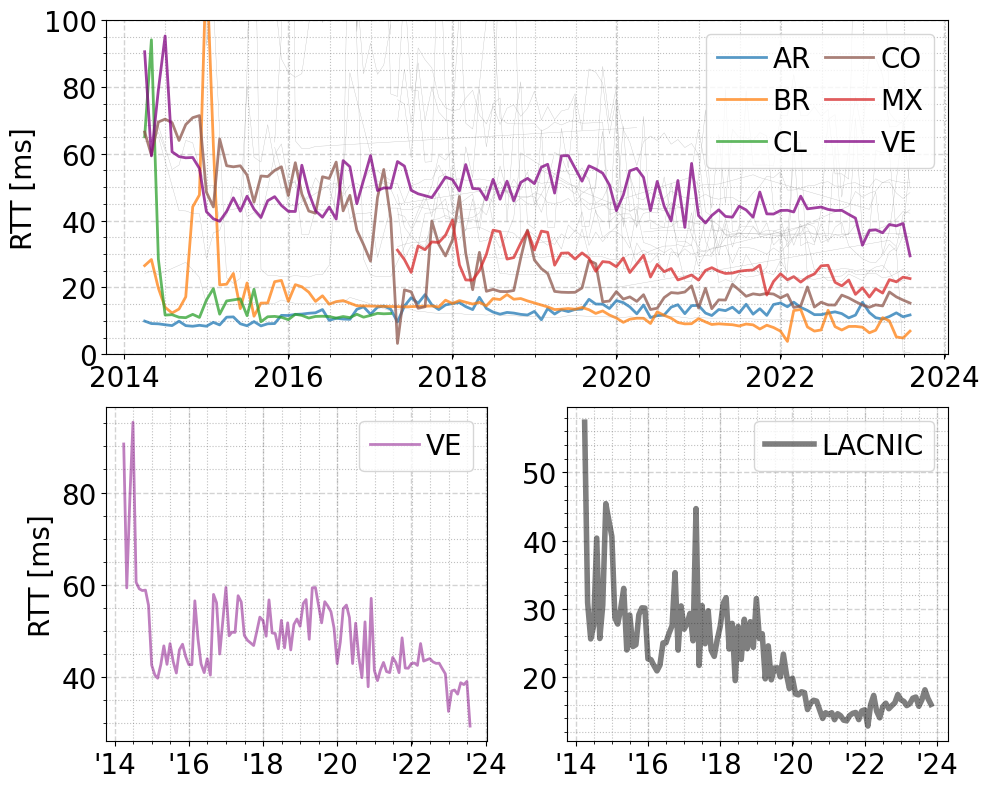

In [12]:
fig = plt.figure(figsize=(10, 8))

gs = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

i = 0
for cc in cc_median_rtts.drop_duplicates("cc")["cc"].values:
    tmp = cc_median_rtts.loc[cc_median_rtts["cc"] == cc]
    tmp = tmp.loc[tmp["median"].notnull()]

    if cc == "BR":
        tmp = tmp.loc[tmp["prbs"] > 10]

    ax1.plot_date(
        tmp["date"],
        tmp["median"],
        label=country_styles[cc]["label"],
        xdate=True,
        ydate=False,
        tz="UTC",
        alpha=country_styles[cc]["alpha"],
        lw=country_styles[cc]["lw"],
        fmt="-",
        marker="None",
        color=country_styles[cc]["color"],
    )

ax1.set_ylabel("RTT [ms]", fontsize=20)
ax1.tick_params(labelsize=20)
ax1.legend(
    loc="upper right",
    ncol=2,
    frameon=True,
    fontsize=20,
    handletextpad=0.25,
    columnspacing=0.5,
    handlelength=1.75,
)

ax1.yaxis.grid(True, linestyle="--", color="darkgrey", lw=1, alpha=0.5, which="major")
ax1.xaxis.grid(True, linestyle="--", color="darkgrey", lw=1, alpha=0.5, which="major")

ax1.yaxis.grid(True, linestyle=":", color="grey", alpha=0.5, which="minor")
ax1.xaxis.grid(True, linestyle=":", color="grey", alpha=0.5, which="minor")

ax1.xaxis.set_major_locator(mdates.YearLocator(2))

ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())

ax1.set_ylim(0, 100)
###
cc = "VE"
tmp = cc_median_rtts.loc[cc_median_rtts["cc"] == cc]
tmp = tmp.loc[tmp["median"].notnull()]

ax2.plot_date(
    tmp["date"],
    tmp["median"],
    xdate=True,
    ydate=False,
    tz="UTC",
    alpha=0.5,
    lw=2,
    fmt="-",
    marker="None",
    color=f"purple",
    label=f"{cc}",
)

ax2.set_ylabel("RTT [ms]", fontsize=20)
ax2.tick_params(labelsize=20)
ax2.legend(
    loc="upper right",
    ncol=2,
    frameon=True,
    fontsize=20,
    handletextpad=0.25,
    columnspacing=0.5,
    handlelength=1.75,
)

ax2.yaxis.grid(True, linestyle="--", color="darkgrey", lw=1, alpha=0.5, which="major")
ax2.xaxis.grid(True, linestyle="--", color="darkgrey", lw=1, alpha=0.5, which="major")

ax2.yaxis.grid(True, linestyle=":", color="grey", alpha=0.5, which="minor")
ax2.xaxis.grid(True, linestyle=":", color="grey", alpha=0.5, which="minor")

ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.xaxis.set_major_formatter(DateFormatter("'%y"))
ax2.xaxis.set_major_locator(mdates.YearLocator(2))
###
cc = "LACNIC"

ax3.plot_date(
    medians_rtt_lacnic["epoch"].values[:-1],
    medians_rtt_lacnic["values"].values[:-1],
    xdate=True,
    ydate=False,
    tz="UTC",
    alpha=0.5,
    lw=4,
    fmt="-",
    marker="None",
    color=f"black",
    label=f"{cc}",
)

ax3.tick_params(labelsize=20)
ax3.legend(
    loc="upper right",
    ncol=2,
    frameon=True,
    fontsize=20,
    handletextpad=0.25,
    columnspacing=0.5,
    handlelength=1.75,
)

ax3.yaxis.grid(True, linestyle="--", color="darkgrey", lw=1, alpha=0.5, which="major")
ax3.xaxis.grid(True, linestyle="--", color="darkgrey", lw=1, alpha=0.5, which="major")

ax3.yaxis.grid(True, linestyle=":", color="grey", alpha=0.5, which="minor")
ax3.xaxis.grid(True, linestyle=":", color="grey", alpha=0.5, which="minor")

ax3.yaxis.set_minor_locator(AutoMinorLocator())
ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.xaxis.set_major_formatter(DateFormatter("'%y"))
ax3.xaxis.set_major_locator(mdates.YearLocator(2))

fig.subplots_adjust(hspace=0)
fig.tight_layout()
fig.savefig("figures/12-google_public_dns_rtt.pdf")

The figure is divided into three segments, each showing the median RTT evolution. The top segment offers a comparative analysis at the country level, emphasizing Venezuela’s latency to its LACNIC peers, with key comparable countries highlighted in bright colors. The bottom left segment focuses on Venezuela, providing a detailed view of its RTT latency trends. In contrast, the bottom right segment aggregates and displays the overall RTT latency trends across the LACNIC region.

Our analysis indicates a consistent reduction in RTT latency across most LACNIC region countries, which aligns with the ongoing expansion of GPDNS infrastructure.


In [13]:
for cc in cc_median_rtts.drop_duplicates("cc")["cc"].values:
    tmp = cc_median_rtts.loc[cc_median_rtts["cc"] == cc]
    tmp = tmp.loc[tmp["median"].notnull()]

    if cc == "BR":
        tmp = tmp.loc[tmp["prbs"] > 10]

    if cc in ["AR", "BR", "MX", "CL", "CO", "VE"]:
        print(
            cc,
            f'{tmp.loc[tmp["date"] > datetime(2015, 12, 31)].head(6)["median"].mean():.2f}',
            f'{tmp.tail(6)["median"].mean():.2f}',
        )

AR 12.27 11.36
BR 18.12 7.52
CL 11.25 11.87
CO 48.48 16.10
MX 30.21 21.28
VE 45.71 36.56


Comparing the first half of 2016 with the latter half of 2023, minor fluctuations are observed in Argentina (from 12.27 ms to 11.36 ms) and Chile (from 11.25 ms to 11.87 ms), alongside notable declines in Colombia (from 48.48 ms to 16.10 ms), Brazil (from 18.12 ms to 7.52 ms), and Mexico (from 30.21 ms to 21.28 ms). While Venezuela also experienced a reduction in RTT latency to GPDNS during this period (from 45.71 ms to 36.56 ms), its progress lags behind those of these countries.

In [14]:
medians_rtt_lacnic.tail(6)["values"].mean()

16.657416666666666

In [15]:
36.56 / 17.73

2.0620417371686406

In [16]:
tmp = cc_median_rtts.loc[cc_median_rtts["cc"] == "VE"]
tmp = tmp.loc[tmp["median"].notnull()]
ve = tmp.tail(6)["median"].mean()

for cc in cc_median_rtts.drop_duplicates("cc")["cc"].values:

    tmp = cc_median_rtts.loc[cc_median_rtts["cc"] == cc]
    tmp = tmp.loc[tmp["median"].notnull()]

    if cc == "BR":
        tmp = tmp.loc[tmp["prbs"] > 10]

    if cc in ["AR", "BR", "MX", "CL", "CO"]:
        print(cc, f'{ve / tmp.tail(6)["median"].mean():.2f}')

AR 3.22
BR 4.86
CL 3.08
CO 2.27
MX 1.72


In the latest measurements, Venezuela’s latency values are still considerably higher, being 3.22 times that of Argentina, 4.86 times Brazil’s, 3.08 times Chile’s, 2.27 times Colombia’s, and 1.72 times Mexico’s. When we compare Venezuela with the region as a whole, Venezuelan users experienced a latency 2.06 times higher (36.56 ms) compared to the LACNIC average (17.74 ms).